In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as web
import datetime as dt
import yfinance as yfin

from pandas_datareader import data as pdr
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

In [10]:
# declare variable
company = 'trv'
start_date = '2012-01-01'
end_date = '2021-01-01'
prediction_days = 60

In [11]:
yfin.pdr_override()
data = pdr.get_data_yahoo(company, start=start_date, end=end_date)
data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-01-03,60.110001,60.320000,58.980000,58.990002,45.250168,3522500
2012-01-04,58.840000,59.070000,58.139999,58.750000,45.066067,3934500
2012-01-05,58.360001,59.360001,58.080002,59.330002,45.510986,4748600
2012-01-06,59.570000,59.730000,59.110001,59.349998,45.526318,2033400
2012-01-09,59.820000,59.880001,59.340000,59.689999,45.787113,1930100
...,...,...,...,...,...,...
2020-12-24,138.059998,138.639999,136.839996,138.490005,131.893723,416800
2020-12-28,138.830002,139.880005,138.470001,139.190002,132.560394,1100300
2020-12-29,139.580002,139.649994,138.029999,138.350006,131.760391,859000


In [12]:
# prepare data
x_train, y_train = [], []
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))

for x in range (prediction_days, len(scaled_data)):
  x_train.append(scaled_data[x-prediction_days : x, 0])
  y_train.append(scaled_data[x, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [13]:
# build the model
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1)) # prediction of the next closing value

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=25, batch_size=32)

Epoch 1/25
69/69 [==============================] - 25s 117ms/step - loss: 0.0280
Epoch 2/25
69/69 [==============================] - 7s 101ms/step - loss: 0.0051
Epoch 3/25
69/69 [==============================] - 8s 110ms/step - loss: 0.0048
Epoch 4/25
69/69 [==============================] - 8s 115ms/step - loss: 0.0044
Epoch 5/25
69/69 [==============================] - 7s 97ms/step - loss: 0.0040
Epoch 6/25
69/69 [==============================] - 9s 128ms/step - loss: 0.0036
Epoch 7/25
69/69 [==============================] - 7s 99ms/step - loss: 0.0042
Epoch 8/25
69/69 [==============================] - 10s 149ms/step - loss: 0.0035
Epoch 9/25
69/69 [==============================] - 8s 118ms/step - loss: 0.0036
Epoch 10/25
69/69 [==============================] - 7s 95ms/step - loss: 0.0034
Epoch 11/25
69/69 [==============================] - 8s 115ms/step - loss: 0.0034
Epoch 12/25
69/69 [==============================] - 7s 100ms/step - loss: 0.0032
Epoch 13/25
69/69 [=======

In [14]:
# load test data
test_start = '2021-01-01'
test_end = '2023-01-01'

test_data = pdr.get_data_yahoo(company, start=test_start, end=test_end)
actual_prices = test_data['Close'].values

total_dataset = pd.concat((data['Close'], test_data['Close']), axis=0)

model_inputs = total_dataset[len(total_dataset) - len(test_data)- prediction_days:].values
model_inputs = model_inputs.reshape(-1, 1)
model_inputs = scaler.transform(model_inputs)

[*********************100%***********************]  1 of 1 completed


16/16 [==============================] - 2s 33ms/step


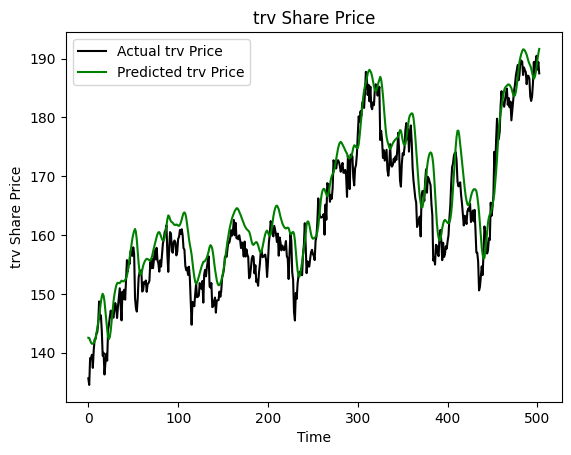

In [15]:
# make predictions on test data
x_test = []

for x in range(prediction_days, len(model_inputs)):
  x_test.append(model_inputs[x-prediction_days:x, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

# plot the test predictions
plt.plot(actual_prices, color='black', label=f'Actual {company} Price')
plt.plot(predicted_prices, color='green', label=f'Predicted {company} Price')
plt.title(f'{company} Share Price')
plt.xlabel('Time')
plt.ylabel(f'{company} Share Price')
plt.legend()
plt.show()

In [16]:
# predict next day
real_data = [model_inputs[len(model_inputs) + 1 - prediction_days:len(model_inputs + 1), 0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))

prediction = model.predict(real_data)
prediction = scaler.inverse_transform(prediction)
print(f"Prediction: {prediction}")

1/1 [==============================] - 1s 1s/step
Prediction: [[191.98137]]
